In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#necessary imports
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
'!ls "/content/drive/My Drive"

 20220418_082855.jpg		     PSX_20200112_010023.jpg	 PSX_20201220_194504.jpg
 Aamina_Binte_Khurram_Resume-1.pdf   PSX_20200323_005852.jpg	 PSX_20201220_203810.jpg
'Colab Notebooks'		     PSX_20200329_190535.jpg	 PSX_20201220_212416.jpg
 Event.gsite			     PSX_20200410_142930~2.jpg	 PSX_20201221_225759.jpg
'images dataset'		     PSX_20200604_225648.jpg	 PSX_20201221_225852.jpg
 IMG-20210719-WA0063~2.jpg	     PSX_20200826_233135.jpg	 PSX_20201221_230310.jpg
'Medical Certificate.pdf'	     PSX_20200903_021127.jpg	 PSX_20210207_214301.jpg
 Portfolio.gsite		     PSX_20201025_123613.jpg	 PSX_20210207_224022.jpg
 PSX_20190925_194414.jpg	     PSX_20201220_190622.jpg	 PSX_20210207_224049.jpg
 PSX_20190930_191853.jpg	     PSX_20201220_191410.jpg	 PSX_20210401_190556.jpg
 PSX_20191009_161338.jpg	     PSX_20201220_191902.jpg	 PSX_20210401_190708.jpg
 PSX_20191026_153843.jpg	     PSX_20201220_192241.jpg	 PSX_20210514_085505.jpg
 PSX_20191026_153931.jpg	     PSX_20201220_192624.jpg	 PSX_20210719_13172

In [5]:
path = "/content/drive/My Drive/images dataset"


In [6]:
# Define transforms for data augmentation and normalization
transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [7]:

train_dataset = datasets.ImageFolder(root=path+"/train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

validation_dataset = datasets.ImageFolder(root=path+"/valid", transform=transform)
validation_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.ImageFolder(root=path+"/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

dataloaders = {'train':train_loader, 'valid':validation_loader, 'test':test_loader}

# Determine dataset sizes
dataset_sizes = {}
dataset_sizes['train'] = len(train_dataset)
dataset_sizes['valid'] = len(validation_dataset)
dataset_sizes['test'] = len(test_dataset)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<H4><b>Model Training

In [8]:
# Define function for training a model
def train_model(model, criterion, optimizer, dataloaders, num_epochs=5):
    model.to(device)
    train_acc_history = []
    valid_acc_history = []

    train_loss_history = []
    valid_loss_history = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # print(inputs)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                train_acc_history.append(epoch_acc)
            else:
                valid_acc_history.append(epoch_acc)

            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                valid_loss_history.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    return model, train_acc_history, valid_acc_history, train_loss_history, valid_loss_history

<h4><b>Model Evaluation

In [1]:
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []

    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        # Collect predictions and true labels
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    print('Accuracy: {:.4f}'.format(accuracy))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1-score: {:.4f}'.format(f1))


<h4><B>VGG16

In [12]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 153MB/s]


In [13]:
# Check the number of input features for the fully connected layer
num_features_vgg16 = model.classifier[6].in_features

# Define the number of classes in your dataset
num_classes = 2

# Modify the fully connected layers
model.classifier[6] = nn.Sequential(
    # nn.Linear(num_features_vgg16, 256),  # Additional linear layer with 256 output features
    # nn.ReLU(inplace=True),         # Activation function
    # nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(num_features_vgg16, num_classes)    # Final prediction fc layer
)

# dropout_prob = 0.5
model_vgg16 = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_vgg16.parameters(), lr=0.0001)

import gc
torch.cuda.empty_cache()
gc.collect()

37

In [14]:
model_5_ep, train_acc_vgg16, valid_acc_vgg16, train_loss_vgg16, valid_loss_vgg16 = train_model(model, criterion, optimizer_ft, dataloaders,
                       num_epochs=5)


Epoch 1/5
----------
train Loss: 0.5594 Acc: 0.7138
valid Loss: 0.5239 Acc: 0.7142
Epoch 2/5
----------
train Loss: 0.4150 Acc: 0.8045
valid Loss: 0.3254 Acc: 0.8672
Epoch 3/5
----------
train Loss: 0.3439 Acc: 0.8419
valid Loss: 0.2752 Acc: 0.8952
Epoch 4/5
----------
train Loss: 0.2746 Acc: 0.8810
valid Loss: 0.1929 Acc: 0.9279
Epoch 5/5
----------
train Loss: 0.2097 Acc: 0.9141
valid Loss: 0.2098 Acc: 0.9113


In [15]:
print("Evaluating vgg16 on the test set...")
evaluate_model(model_5_ep, dataloaders['test'])

Evaluating vgg16 on the test set...
Accuracy: 0.8233
Precision: 0.9619
Recall: 0.6733
F1-score: 0.7922


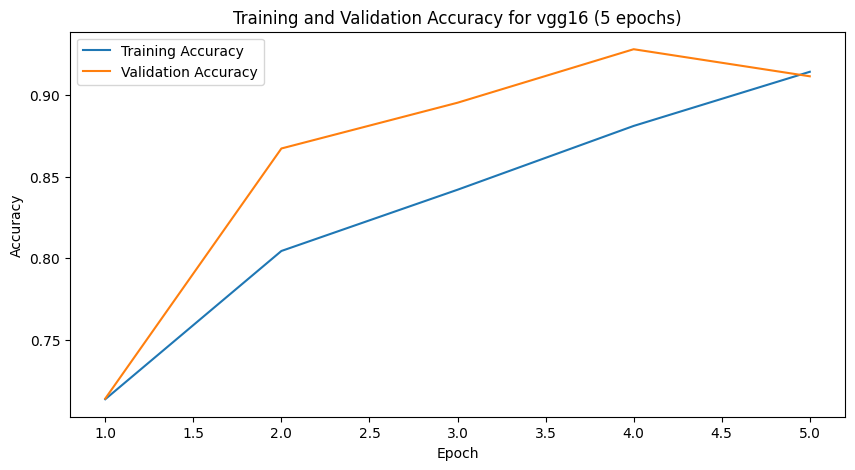

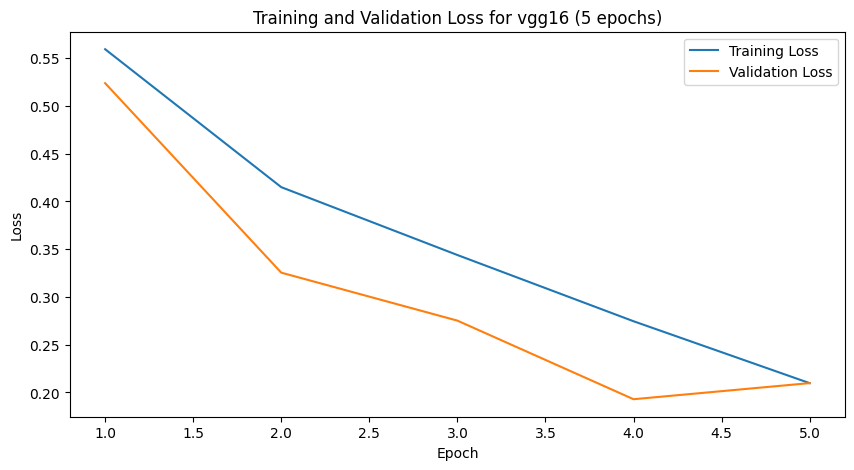

In [16]:
# Move the accuracies to CPU
train_acc_vgg16_cpu = [acc.cpu().numpy() for acc in train_acc_vgg16]
valid_acc_vgg16_cpu = [acc.cpu().numpy() for acc in valid_acc_vgg16]
# print(train_acc_resnet34)
# print(train_loss_resnet34)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_vgg16_cpu) + 1), train_acc_vgg16_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_vgg16_cpu) + 1), valid_acc_vgg16_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for vgg16 (5 epochs)')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_vgg16) + 1), train_loss_vgg16, label='Training Loss')
plt.plot(range(1, len(valid_loss_vgg16) + 1), valid_loss_vgg16, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for vgg16 (5 epochs)')
plt.legend()
plt.show()

In [17]:
model_10_ep, train_acc_vgg16, valid_acc_vgg16, train_loss_vgg16, valid_loss_vgg16 = train_model(model, criterion, optimizer_ft, dataloaders,
                       num_epochs=10)


Epoch 1/10
----------
train Loss: 0.2015 Acc: 0.9204
valid Loss: 0.1410 Acc: 0.9535
Epoch 2/10
----------
train Loss: 0.1180 Acc: 0.9523
valid Loss: 0.0661 Acc: 0.9791
Epoch 3/10
----------
train Loss: 0.0925 Acc: 0.9653
valid Loss: 0.1776 Acc: 0.9231
Epoch 4/10
----------
train Loss: 0.0957 Acc: 0.9610
valid Loss: 0.0824 Acc: 0.9693
Epoch 5/10
----------
train Loss: 0.0920 Acc: 0.9653
valid Loss: 0.0671 Acc: 0.9771
Epoch 6/10
----------
train Loss: 0.0572 Acc: 0.9807
valid Loss: 0.0457 Acc: 0.9854
Epoch 7/10
----------
train Loss: 0.0505 Acc: 0.9787
valid Loss: 0.0646 Acc: 0.9720
Epoch 8/10
----------
train Loss: 0.0331 Acc: 0.9886
valid Loss: 0.0075 Acc: 0.9976
Epoch 9/10
----------
train Loss: 0.0640 Acc: 0.9736
valid Loss: 0.0386 Acc: 0.9850
Epoch 10/10
----------
train Loss: 0.0181 Acc: 0.9945
valid Loss: 0.0094 Acc: 0.9965


In [18]:
print("Evaluating vgg16 on the test set...")
evaluate_model(model_10_ep, dataloaders['test'])

Evaluating vgg16 on the test set...
Accuracy: 0.8800
Precision: 0.9014
Recall: 0.8533
F1-score: 0.8767


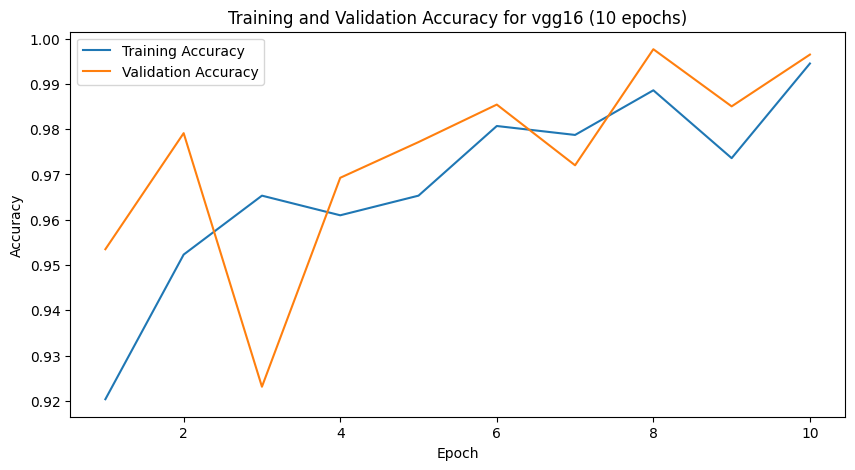

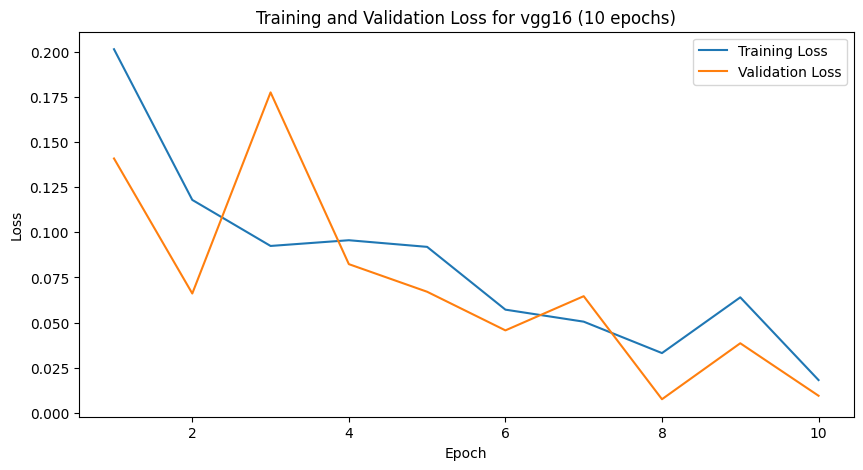

In [19]:
# Move the accuracies to CPU
train_acc_vgg16_cpu = [acc.cpu().numpy() for acc in train_acc_vgg16]
valid_acc_vgg16_cpu = [acc.cpu().numpy() for acc in valid_acc_vgg16]
# print(train_acc_resnet34)
# print(train_loss_resnet34)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_vgg16_cpu) + 1), train_acc_vgg16_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_vgg16_cpu) + 1), valid_acc_vgg16_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for vgg16 (10 epochs)')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_vgg16) + 1), train_loss_vgg16, label='Training Loss')
plt.plot(range(1, len(valid_loss_vgg16) + 1), valid_loss_vgg16, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for vgg16 (10 epochs)')
plt.legend()
plt.show()

<h4><B>VGG19

In [20]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 152MB/s]


In [21]:
# Check the number of input features for the fully connected layer
num_features_vgg19 = model.classifier[6].in_features

# Define the number of classes in your dataset
num_classes = 2

# Modify the fully connected layers
model.classifier[6] = nn.Sequential(
    # nn.Linear(num_features_vgg19, 256),  # Additional linear layer with 256 output features
    # nn.ReLU(inplace=True),         # Activation function
    # nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(num_features_vgg19, num_classes)    # Final prediction fc layer
)

dropout_prob = 0.5
model_vgg19 = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_vgg19.parameters(), lr=0.0001)

import gc
torch.cuda.empty_cache()
gc.collect()

15629

In [22]:
model_5_ep, train_acc_vgg19, valid_acc_vgg19, train_loss_vgg19, valid_loss_vgg19 = train_model(model, criterion, optimizer_ft, dataloaders,
                       num_epochs=5)


Epoch 1/5
----------
train Loss: 0.5030 Acc: 0.7513
valid Loss: 0.4491 Acc: 0.7828
Epoch 2/5
----------
train Loss: 0.4229 Acc: 0.8112
valid Loss: 0.2867 Acc: 0.8794
Epoch 3/5
----------
train Loss: 0.3470 Acc: 0.8502
valid Loss: 0.2673 Acc: 0.8948
Epoch 4/5
----------
train Loss: 0.2707 Acc: 0.8873
valid Loss: 0.1732 Acc: 0.9334
Epoch 5/5
----------
train Loss: 0.2036 Acc: 0.9141
valid Loss: 0.1539 Acc: 0.9361


In [23]:
print("Evaluating vgg19 on the test set...")
evaluate_model(model_5_ep, dataloaders['test'])

Evaluating vgg19 on the test set...
Accuracy: 0.8900
Precision: 0.8462
Recall: 0.9533
F1-score: 0.8966


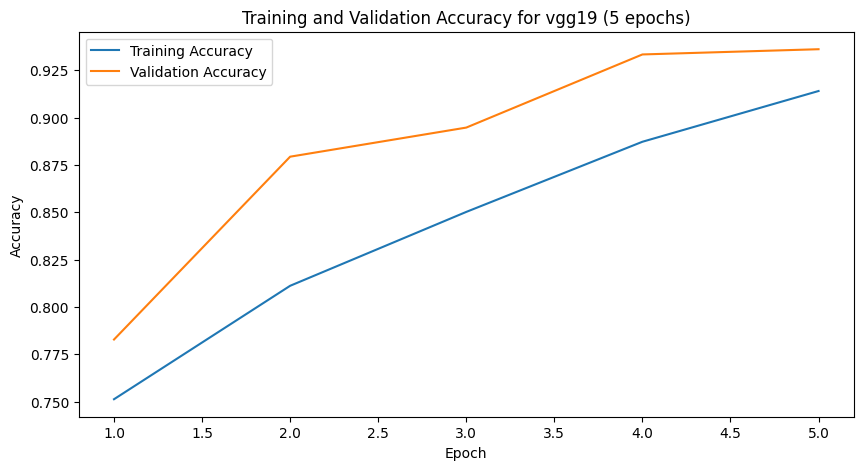

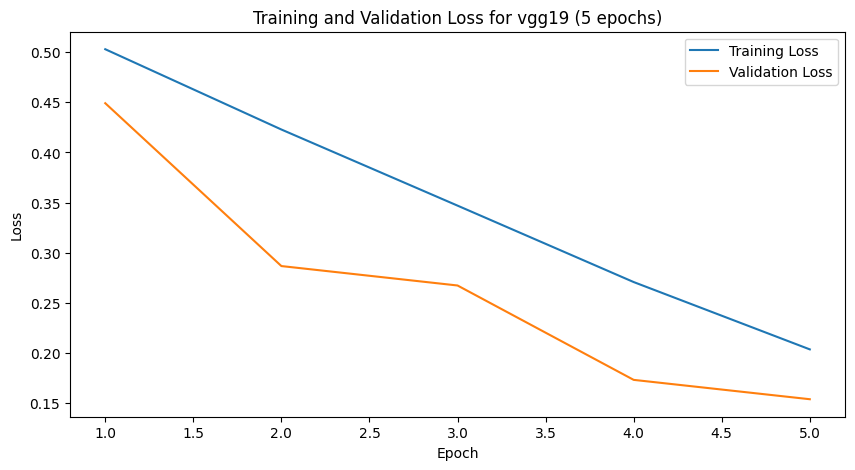

In [24]:
# Move the accuracies to CPU
train_acc_vgg19_cpu = [acc.cpu().numpy() for acc in train_acc_vgg19]
valid_acc_vgg19_cpu = [acc.cpu().numpy() for acc in valid_acc_vgg19]
# print(train_acc_resnet34)
# print(train_loss_resnet34)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_vgg19_cpu) + 1), train_acc_vgg19_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_vgg19_cpu) + 1), valid_acc_vgg19_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for vgg19 (5 epochs)')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_vgg19) + 1), train_loss_vgg19, label='Training Loss')
plt.plot(range(1, len(valid_loss_vgg19) + 1), valid_loss_vgg19, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for vgg19 (5 epochs)')
plt.legend()
plt.show()

In [25]:
model, train_acc_vgg19, valid_acc_vgg19, train_loss_vgg19, valid_loss_vgg19 = train_model(model, criterion, optimizer_ft, dataloaders,
                       num_epochs=10)


Epoch 1/10
----------
train Loss: 0.1967 Acc: 0.9208
valid Loss: 0.2368 Acc: 0.8983
Epoch 2/10
----------
train Loss: 0.1824 Acc: 0.9251
valid Loss: 0.1343 Acc: 0.9488
Epoch 3/10
----------
train Loss: 0.1071 Acc: 0.9633
valid Loss: 0.0393 Acc: 0.9886
Epoch 4/10
----------
train Loss: 0.0793 Acc: 0.9744
valid Loss: 0.0511 Acc: 0.9838
Epoch 5/10
----------
train Loss: 0.0813 Acc: 0.9712
valid Loss: 0.0631 Acc: 0.9760
Epoch 6/10
----------
train Loss: 0.0652 Acc: 0.9728
valid Loss: 0.2826 Acc: 0.9074
Epoch 7/10
----------
train Loss: 0.0834 Acc: 0.9685
valid Loss: 0.1012 Acc: 0.9547
Epoch 8/10
----------
train Loss: 0.0580 Acc: 0.9787
valid Loss: 0.0353 Acc: 0.9874
Epoch 9/10
----------
train Loss: 0.0542 Acc: 0.9783
valid Loss: 0.0134 Acc: 0.9957
Epoch 10/10
----------
train Loss: 0.0505 Acc: 0.9811
valid Loss: 0.1391 Acc: 0.9361


In [26]:
print("Evaluating vgg19 on the test set...")
evaluate_model(model_10_ep, dataloaders['test'])

Evaluating vgg19 on the test set...
Accuracy: 0.8833
Precision: 0.8966
Recall: 0.8667
F1-score: 0.8814


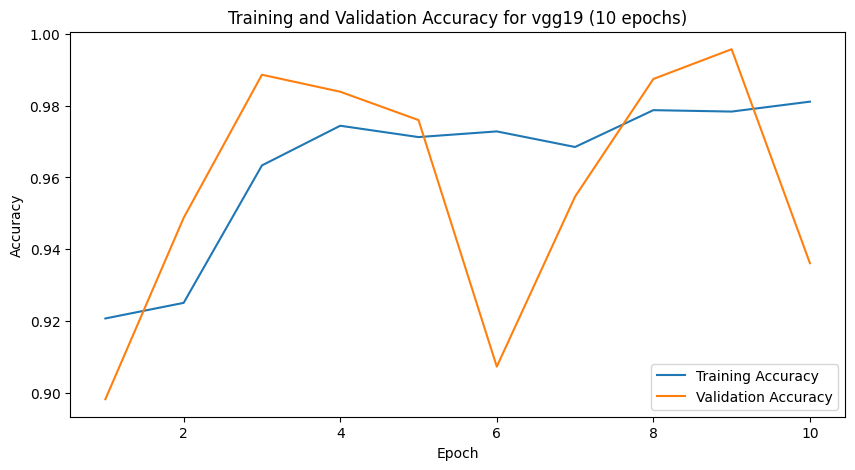

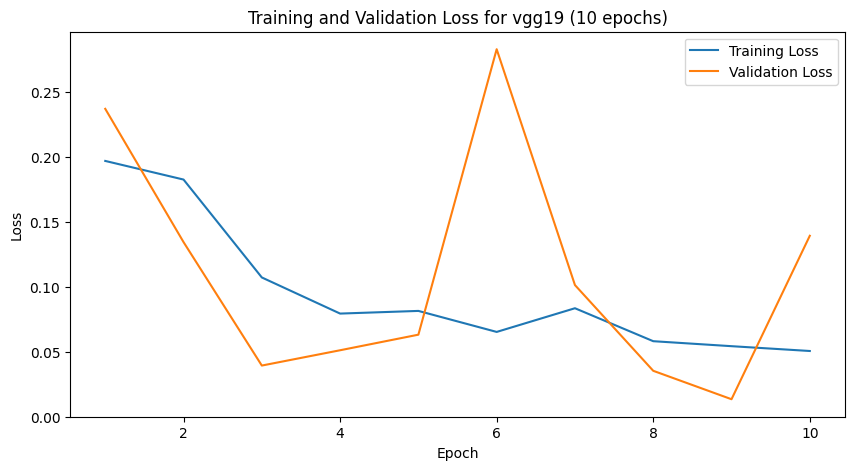

In [27]:
# Move the accuracies to CPU
train_acc_vgg19_cpu = [acc.cpu().numpy() for acc in train_acc_vgg19]
valid_acc_vgg19_cpu = [acc.cpu().numpy() for acc in valid_acc_vgg19]
# print(train_acc_resnet34)
# print(train_loss_resnet34)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_vgg19_cpu) + 1), train_acc_vgg19_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_vgg19_cpu) + 1), valid_acc_vgg19_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for vgg19 (10 epochs)')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_vgg19) + 1), train_loss_vgg19, label='Training Loss')
plt.plot(range(1, len(valid_loss_vgg19) + 1), valid_loss_vgg19, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for vgg19 (10 epochs)')
plt.legend()
plt.show()

<h4><b>ResNet18

In [28]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


In [29]:
# Modify the model head for fine-tuning
num_features_resnet18 = model.fc.in_features

num_classes = 2

# Additional linear layer and dropout layer
model.fc = nn.Sequential(
    # nn.Linear(model_resnet18, 256),  # Additional linear layer with 256 output features
    # nn.ReLU(inplace=True),         # Activation function
    # nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(num_features_resnet18, num_classes)    # Final prediction fc layer
)

dropout_prob = 0.5

# model.fc = nn.Sequential(nn.Linear(num_ftrs, 2))

model_resnet18 = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_resnet18.parameters(), lr=0.0001)

import gc
torch.cuda.empty_cache()
gc.collect()

15412

In [30]:
model_5_ep, train_acc_resnet18, valid_acc_resnet18, train_loss_resnet18, valid_loss_resnet18 = train_model(model, criterion, optimizer_ft, dataloaders,
                       num_epochs=5)


Epoch 1/5
----------
train Loss: 0.4470 Acc: 0.7899
valid Loss: 0.1879 Acc: 0.9361
Epoch 2/5
----------
train Loss: 0.1970 Acc: 0.9216
valid Loss: 0.1674 Acc: 0.9310
Epoch 3/5
----------
train Loss: 0.1150 Acc: 0.9566
valid Loss: 0.0602 Acc: 0.9795
Epoch 4/5
----------
train Loss: 0.0825 Acc: 0.9700
valid Loss: 0.0530 Acc: 0.9834
Epoch 5/5
----------
train Loss: 0.0949 Acc: 0.9657
valid Loss: 0.0419 Acc: 0.9882


In [31]:
print("Evaluating resnet18 on the test set...")
evaluate_model(model_5_ep, dataloaders['test'])

Evaluating resnet18 on the test set...
Accuracy: 0.9033
Precision: 0.9007
Recall: 0.9067
F1-score: 0.9037


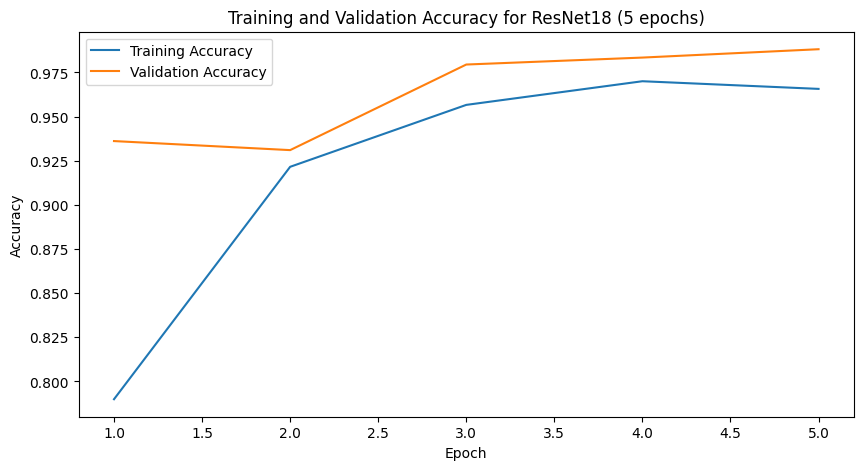

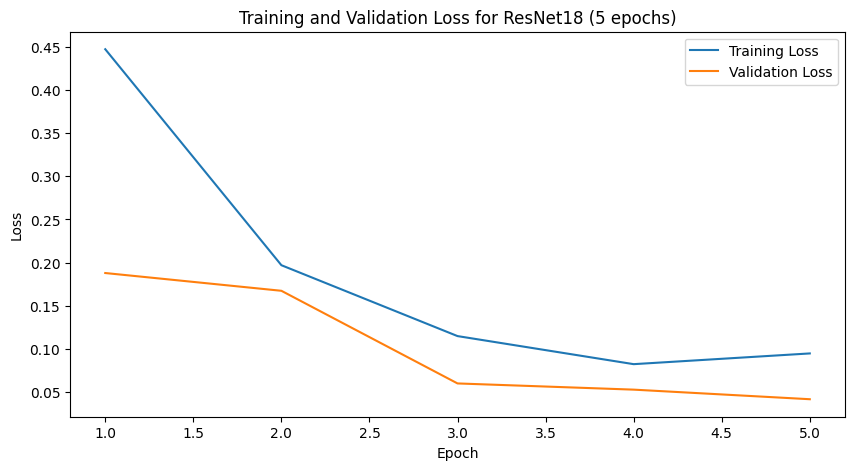

In [32]:
# Move the accuracies to CPU
train_acc_resnet18_cpu = [acc.cpu().numpy() for acc in train_acc_resnet18]
valid_acc_resnet18_cpu = [acc.cpu().numpy() for acc in valid_acc_resnet18]
# print(train_acc_resnet34)
# print(train_loss_resnet34)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_resnet18_cpu) + 1), train_acc_resnet18_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_resnet18_cpu) + 1), valid_acc_resnet18_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet18 (5 epochs)')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_resnet18) + 1), train_loss_resnet18, label='Training Loss')
plt.plot(range(1, len(valid_loss_resnet18) + 1), valid_loss_resnet18, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet18 (5 epochs)')
plt.legend()
plt.show()

In [33]:
model_10_ep, train_acc_resnet18, valid_acc_resnet18, train_loss_resnet18, valid_loss_resnet18 = train_model(model, criterion, optimizer_ft, dataloaders,
                       num_epochs=10)


Epoch 1/10
----------
train Loss: 0.0546 Acc: 0.9834
valid Loss: 0.0212 Acc: 0.9957
Epoch 2/10
----------
train Loss: 0.0240 Acc: 0.9917
valid Loss: 0.0093 Acc: 0.9976
Epoch 3/10
----------
train Loss: 0.0275 Acc: 0.9917
valid Loss: 0.0132 Acc: 0.9976
Epoch 4/10
----------
train Loss: 0.0311 Acc: 0.9886
valid Loss: 0.0113 Acc: 0.9976
Epoch 5/10
----------
train Loss: 0.0325 Acc: 0.9886
valid Loss: 0.0641 Acc: 0.9783
Epoch 6/10
----------
train Loss: 0.0629 Acc: 0.9791
valid Loss: 0.0629 Acc: 0.9752
Epoch 7/10
----------
train Loss: 0.0360 Acc: 0.9882
valid Loss: 0.0139 Acc: 0.9957
Epoch 8/10
----------
train Loss: 0.0390 Acc: 0.9858
valid Loss: 0.0118 Acc: 0.9961
Epoch 9/10
----------
train Loss: 0.0205 Acc: 0.9937
valid Loss: 0.0048 Acc: 0.9988
Epoch 10/10
----------
train Loss: 0.0391 Acc: 0.9882
valid Loss: 0.0093 Acc: 0.9980


In [34]:
print("Evaluating resnet18 on the test set...")
evaluate_model(model_10_ep, dataloaders['test'])

Evaluating resnet18 on the test set...
Accuracy: 0.8933
Precision: 0.8933
Recall: 0.8933
F1-score: 0.8933


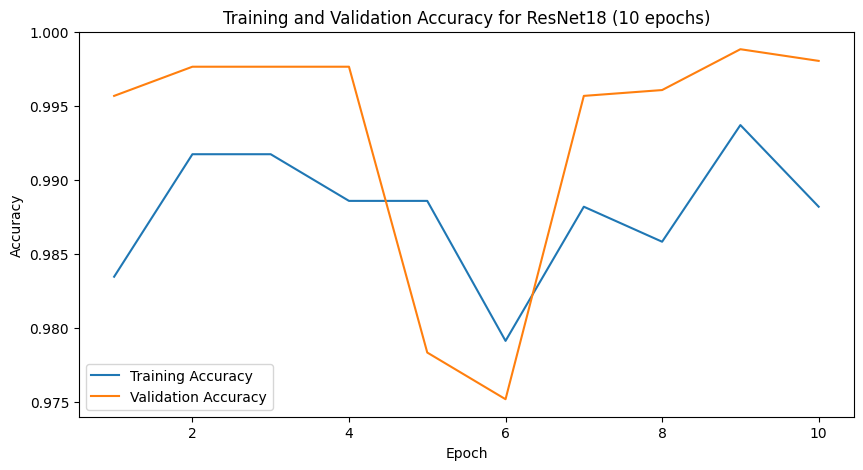

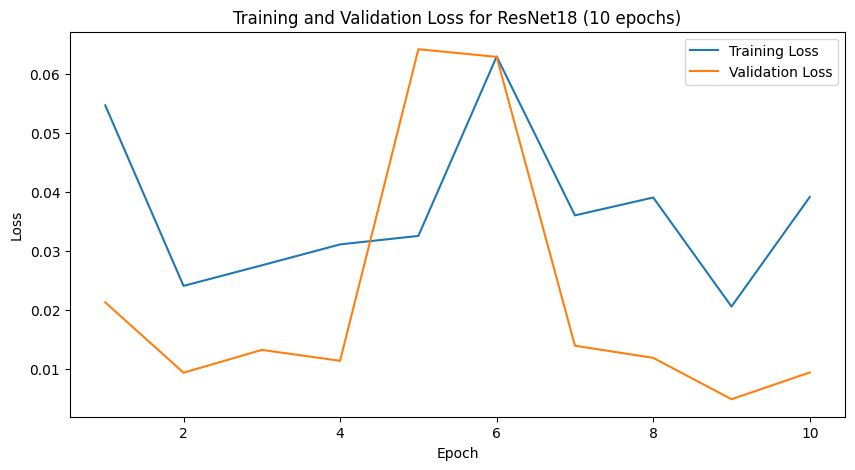

In [35]:
# Move the accuracies to CPU
train_acc_resnet18_cpu = [acc.cpu().numpy() for acc in train_acc_resnet18]
valid_acc_resnet18_cpu = [acc.cpu().numpy() for acc in valid_acc_resnet18]
# print(train_acc_resnet34)
# print(train_loss_resnet34)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_resnet18_cpu) + 1), train_acc_resnet18_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_resnet18_cpu) + 1), valid_acc_resnet18_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet18 (10 epochs)')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_resnet18) + 1), train_loss_resnet18, label='Training Loss')
plt.plot(range(1, len(valid_loss_resnet18) + 1), valid_loss_resnet18, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet18 (10 epochs)')
plt.legend()
plt.show()

<h4><b>ResNet34

In [10]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 42.2MB/s]


In [11]:
# Modify the model head for fine-tuning
num_features_resnet34 = model.fc.in_features

num_classes = 2

# Additional linear layer and dropout layer
model.fc = nn.Sequential(
    # nn.Linear(model_resnet34, 256),  # Additional linear layer with 256 output features
    # nn.ReLU(inplace=True),         # Activation function
    # nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(num_features_resnet34, num_classes)    # Final prediction fc layer
)

dropout_prob = 0.5

# model.fc = nn.Sequential(nn.Linear(num_ftrs, 2))

model_resnet34 = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_resnet34.parameters(), lr=0.0001)

import gc
torch.cuda.empty_cache()
gc.collect()

21

In [12]:
model_5_ep, train_acc_resnet34, valid_acc_resnet34, train_loss_resnet34, valid_loss_resnet34 = train_model(model, criterion, optimizer_ft, dataloaders,
                       num_epochs=5)


Epoch 1/5
----------
train Loss: 0.4449 Acc: 0.7978
valid Loss: 0.2053 Acc: 0.9235
Epoch 2/5
----------
train Loss: 0.2232 Acc: 0.9105
valid Loss: 0.1262 Acc: 0.9515
Epoch 3/5
----------
train Loss: 0.1304 Acc: 0.9503
valid Loss: 0.0696 Acc: 0.9728
Epoch 4/5
----------
train Loss: 0.1115 Acc: 0.9547
valid Loss: 0.0368 Acc: 0.9886
Epoch 5/5
----------
train Loss: 0.0771 Acc: 0.9693
valid Loss: 0.1231 Acc: 0.9499


In [13]:
print("Evaluating resnet34 on the test set...")
evaluate_model(model_5_ep, dataloaders['test'])

Evaluating resnet34 on the test set...
Accuracy: 0.8533
Precision: 0.9274
Recall: 0.7667
F1-score: 0.8394


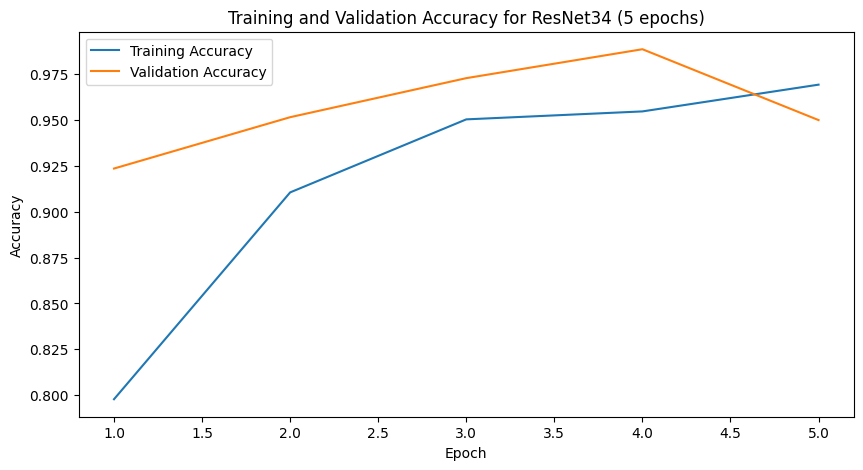

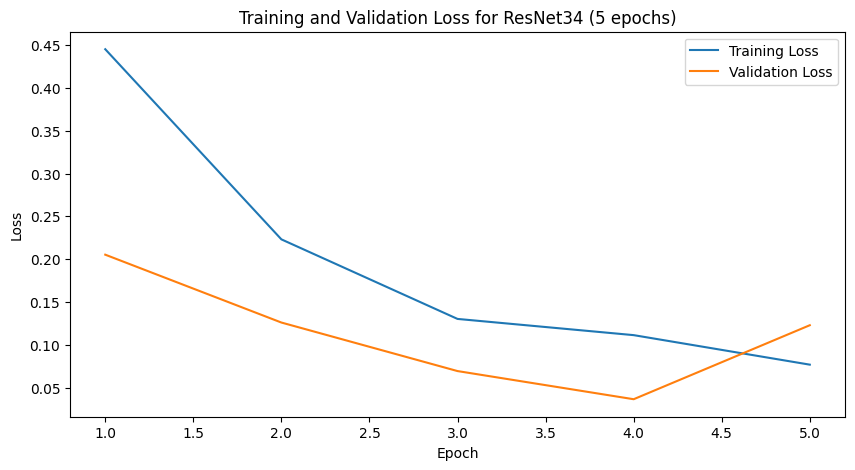

In [14]:
# Move the accuracies to CPU
train_acc_resnet34_cpu = [acc.cpu().numpy() for acc in train_acc_resnet34]
valid_acc_resnet34_cpu = [acc.cpu().numpy() for acc in valid_acc_resnet34]
# print(train_acc_resnet34)
# print(train_loss_resnet34)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_resnet34_cpu) + 1), train_acc_resnet34_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_resnet34_cpu) + 1), valid_acc_resnet34_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet34 (5 epochs)')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_resnet34) + 1), train_loss_resnet34, label='Training Loss')
plt.plot(range(1, len(valid_loss_resnet34) + 1), valid_loss_resnet34, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet34 (5 epochs)')
plt.legend()
plt.show()

In [15]:
model_10_ep, train_acc_resnet34, valid_acc_resnet34, train_loss_resnet34, valid_loss_resnet34 = train_model(model, criterion, optimizer_ft, dataloaders,
                       num_epochs=10)


Epoch 1/10
----------
train Loss: 0.1045 Acc: 0.9633
valid Loss: 0.1531 Acc: 0.9417
Epoch 2/10
----------
train Loss: 0.0635 Acc: 0.9787
valid Loss: 0.0191 Acc: 0.9937
Epoch 3/10
----------
train Loss: 0.0507 Acc: 0.9834
valid Loss: 0.0174 Acc: 0.9961
Epoch 4/10
----------
train Loss: 0.0260 Acc: 0.9913
valid Loss: 0.0129 Acc: 0.9968
Epoch 5/10
----------
train Loss: 0.0258 Acc: 0.9913
valid Loss: 0.0070 Acc: 0.9980
Epoch 6/10
----------
train Loss: 0.0270 Acc: 0.9898
valid Loss: 0.0090 Acc: 0.9972
Epoch 7/10
----------
train Loss: 0.0451 Acc: 0.9854
valid Loss: 0.0111 Acc: 0.9972
Epoch 8/10
----------
train Loss: 0.0345 Acc: 0.9862
valid Loss: 0.0135 Acc: 0.9953
Epoch 9/10
----------
train Loss: 0.0272 Acc: 0.9886
valid Loss: 0.0082 Acc: 0.9980
Epoch 10/10
----------
train Loss: 0.0226 Acc: 0.9913
valid Loss: 0.0092 Acc: 0.9965


In [2]:
print("Evaluating resnet34 on the test set...")
evaluate_model(model_10_ep, dataloaders['test'])

Evaluating resnet34 on the test set...


NameError: name 'model_10_ep' is not defined

In [ ]:
# Move the accuracies to CPU
train_acc_resnet34_cpu = [acc.cpu().numpy() for acc in train_acc_resnet34]
valid_acc_resnet34_cpu = [acc.cpu().numpy() for acc in valid_acc_resnet34]
# print(train_acc_resnet34)
# print(train_loss_resnet34)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_resnet34_cpu) + 1), train_acc_resnet34_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_resnet34_cpu) + 1), valid_acc_resnet34_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet34 (10 epochs)')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_resnet34) + 1), train_loss_resnet34, label='Training Loss')
plt.plot(range(1, len(valid_loss_resnet34) + 1), valid_loss_resnet34, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet34 (10 epochs)')
plt.legend()
plt.show()

<h4><b>ResNet50

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

In [ ]:
# Modify the model head for fine-tuning
num_features_resnet50 = model.fc.in_features

num_classes = 2

# Additional linear layer and dropout layer
model.fc = nn.Sequential(
    # nn.Linear(model_resnet50, 256),  # Additional linear layer with 256 output features
    # nn.ReLU(inplace=True),         # Activation function
    # nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(num_features_resnet50, num_classes)    # Final prediction fc layer
)

dropout_prob = 0.5

# model.fc = nn.Sequential(nn.Linear(num_ftrs, 2))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.0001)

import gc
torch.cuda.empty_cache()
gc.collect()

In [ ]:
model_5_ep, train_acc_resnet50, valid_acc_resnet50, train_loss_resnet50, valid_loss_resnet50 = train_model(model, criterion, optimizer_ft, dataloaders,
                       num_epochs=5)


In [ ]:
print("Evaluating resnet50 on the test set...")
evaluate_model(model_5_ep, dataloaders['test'])

In [ ]:
# Move the accuracies to CPU
train_acc_resnet50_cpu = [acc.cpu().numpy() for acc in train_acc_resnet50]
valid_acc_resnet50_cpu = [acc.cpu().numpy() for acc in valid_acc_resnet50]
# print(train_acc_resnet34)
# print(train_loss_resnet34)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_resnet50_cpu) + 1), train_acc_resnet50_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_resnet50_cpu) + 1), valid_acc_resnet50_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet50 (5 epochs)')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_resnet50) + 1), train_loss_resnet50, label='Training Loss')
plt.plot(range(1, len(valid_loss_resnet50) + 1), valid_loss_resnet50, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet50 (5 epochs)')
plt.legend()
plt.show()

In [ ]:
model_10_ep, train_acc_resnet50, valid_acc_resnet50, train_loss_resnet50, valid_loss_resnet50 = train_model(model, criterion, optimizer_ft, dataloaders,
                       num_epochs=10)


In [ ]:
print("Evaluating ResNet50 on the test set...")
evaluate_model(model, dataloaders['test'])

In [ ]:
# Move the accuracies to CPU
train_acc_resnet50_cpu = [acc.cpu().numpy() for acc in train_acc_resnet50]
valid_acc_resnet50_cpu = [acc.cpu().numpy() for acc in valid_acc_resnet50]
# print(train_acc_resnet34)
# print(train_loss_resnet34)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_resnet50_cpu) + 1), train_acc_resnet50_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_resnet50_cpu) + 1), valid_acc_resnet50_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet50 (10 epochs)')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_resnet50) + 1), train_loss_resnet50, label='Training Loss')
plt.plot(range(1, len(valid_loss_resnet50) + 1), valid_loss_resnet50, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet50 (10 epochs)')
plt.legend()
plt.show()